In [8]:
import networkx as nx
import csv
import numpy as np
import matplotlib.pyplot as plt
import random
import operator
from pyvis.network import Network
from tqdm import tqdm
import pickle


# 1. Process The Data
- In this module, we will read in the graph data, and apply several techniques to clean the data so that it is more relevant for later analysis.
- Once this basic processing is done, we will build-upon/enhance the information structure of our graph using the spotify api to gather tracks that can be used as edges. We will also apply some different possible weighting attributes to edges.
- In the end, 2 Graph objects will be saved and serialized. One basic graph of artist to artist collaboration, and another: temporal, multigraph where each edge represents a specific track of collaboration.


In [9]:
# Paths for node and edge dataset files
NODES_PATH = './data/nodes.csv'
EDGES_PATH = './data/edges.csv'

## Reading in the Data
Here, the raw csv data will be read in, producing the first version of our basic graph and a dictionarty of attributes. Only the artists that pass a certain popularity threshhold will be added.

In [10]:
import ast

MIN_POPULARITY = 15

G = nx.Graph()
artist_info = dict()

with open(NODES_PATH, 'r', encoding='utf-8') as file:
    file_data = csv.reader(file)
    i = 0
    for row in file_data:
        if i == 0:
            i += 1
            continue
        uri = row[0]
        name = row[1]
        popularity = int(row[3])
        genres = ast.literal_eval(row[4])

        if popularity > MIN_POPULARITY:
            G.add_node(uri)
            artist_info[uri] = (name, popularity, genres)
            

with open(EDGES_PATH, 'r') as file:
    file_data = csv.reader(file)
    i = 0
    for row in file_data:
        if i == 0:
            i += 1
            continue
        uri_0 = row[0]
        uri_1 = row[1]

        if G.has_node(uri_0) and G.has_node(uri_1):
            G.add_edge(uri_0, uri_1)

print("Number of nodes:", G.number_of_nodes())
print("Number of edges:", G.number_of_edges())

Number of nodes: 84250
Number of edges: 220381


## Cleaning graph by component size and connectivity
First we remove trivial, isolated verticies from the graph:

In [12]:
# Remove trivial Components
trival_verticies = list(nx.isolates(G))
G.remove_nodes_from(trival_verticies)

print(f"Removed {len(trival_verticies)} trival verticies` from Graph")

Removed 2255 trival verticies` from Graph


Analyzing size distribution of the connected components:

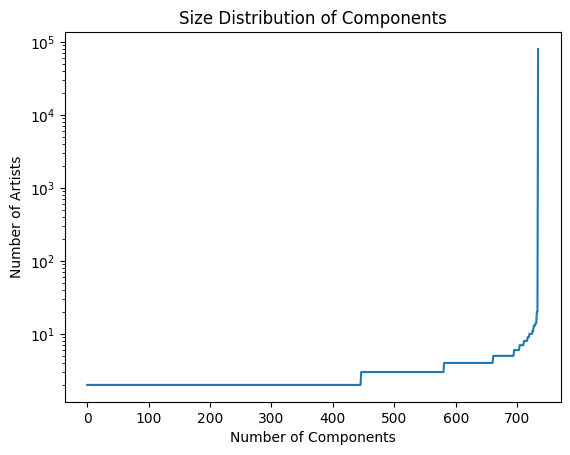

One MASSIVE component of size: 79851
Takes up 97.39% of all verticies in the Graph


In [13]:
# Look at compo distribution and clip to the graph to only be the largest component
component_sizes = sorted([len(cc) for cc in nx.connected_components(G)])

fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(component_sizes)
ax.set_yscale('log')
plt.title("Size Distribution of Components")
ax.set_xlabel("Number of Components")
ax.set_ylabel("Number of Artists")
plt.show()

print(f"One MASSIVE component of size: {component_sizes[-1]}")
print(f"Takes up {(component_sizes[-1] / G.number_of_nodes())*100:.2f}% of all verticies in the Graph")

Given, the massive size of this one component, we decided to only consider vertices within this component for simpicity and relevancy in later analyses. Thus, we remove all other components, making the graph now fully connected.

In [14]:
# Clip the graph to only consider largest component
print(f"Removed {sum(component_sizes[:-1])} vertices, not part of the massive component.")
G = G.subgraph(sorted(nx.connected_components(G))[0])

Removed 2144 vertices, not part of the massive component.


## Filtering by Genre Metadata

In [15]:
# Do some filtering by genre

## Computing the multigraph

## Calculating and adding various edge weights

## Outputting some basic stats about our network

In [16]:
# Basic Graph Stats we will be working with

avg_degree = round(np.mean([degree for (_, degree) in G.degree()]))

print("Number of nodes:", G.number_of_nodes())
print("Number of edges:", G.number_of_edges())
print("Average Degree:", avg_degree)

Number of nodes: 79851
Number of edges: 218961
Average Degree: 5


## Saving the objects

In [17]:
# Save Graph
with open("./saved_objects/main_graph.pkl", "wb") as f:
    pickle.dump(G, f)
with open("./saved_objects/artist_info.pkl", "wb") as f:
    pickle.dump(artist_info, f)